# 12-02: Laplacian Spectrum of Complex networks

*January 25 2023*  

In the second session we use the Laplacian spectrum introduced in lecture 12 to analyse networks. In a first task we use the algebraic connectivity to quantify how ''well-connected'' a network is.

In [1]:
import pathpy as pp
import numpy as np
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")
    
from numpy import linalg as npl
import scipy as sp

## Laplacian matrix and algebraic connectivity 

We first implement two functions `laplacian` and `algconn` that return the Laplacian matrix and the algebraic connectivity of a given (undirected and unweighted) network.

In [2]:
def laplacian(network):
    A = network.adjacency_matrix()
    D = sp.sparse.diags(pp.statistics.degree_sequence(network))
    L = D - A
    return L

def algconn(network):
    L = laplacian(network)
    # "SM" stands for smallest magnitude, k=2 yields the first two eigenvalues in the sorted sequence
    w = sp.sparse.linalg.eigs(L, which="SM", k=2, return_eigenvectors=False)
    eigenvalues_sorted = np.sort(np.absolute(w))
    return eigenvalues_sorted[1]

We test those functions in our (standard) toy example. We also compare the value of the algebraic connectivity to the value given in lecture 12, slide 15.

In [4]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('b', 'd')
n.add_edge('d', 'f')
n.add_edge('d', 'g')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('f', 'g')

n.plot(edge_color='gray')

print(laplacian(n).todense())
print('Alegbraic connectivity =', algconn(n))

[[ 2. -1. -1.  0.  0.  0.  0.]
 [-1.  3. -1. -1.  0.  0.  0.]
 [-1. -1.  2.  0.  0.  0.  0.]
 [ 0. -1.  0.  4. -1. -1. -1.]
 [ 0.  0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0. -1. -1.  2.  0.]
 [ 0.  0.  0. -1. -1.  0.  2.]]
Alegbraic connectivity = 0.39832086811684403


Let us remove the connecting edge `(b,d)` between the two clusters and recompute the algebraic connectivity.

In [6]:
n.remove_edge('b', 'd')
n.plot(edge_color='gray')
print('Algebraic connectivity =', algconn(n))

[01-24 21:13:24: WARNING] No edge was removed!


Algebraic connectivity = 2.9212511988402553e-16


Due to numerical precision, we do not get a zero value, but it is zero up to the default tolerance for numerical precision used in numpy.

In [7]:
np.isclose(algconn(n), 0)

True

## Algebraic connectivity in networks with cluster structures

We now generate a network that consists of two separate connected components, each being a Erdoes-Renyi network with with $100$ nodes and $np =10$. For this, we use the `+`-operator in `pathpy`, which generates the union of two networks.

In [8]:
n = 100
p = 10/n
random_1 = pp.generators.random_graphs.ER_np(n, p, node_uids=[str(i) for i in range(n)])
random_2 = pp.generators.random_graphs.ER_np(n, p, node_uids=[str(i+n) for i in range(n)])
network = random_1 + random_2
print(network)

Uid:			0x27e713533a0
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	200
Number of edges:	996


If we compute the algebraic connectivity of this network, we again find a value that is again numerically zero, because the two networks are not connected:

In [9]:
print(algconn(network))

1.577431485714873e-15


In [10]:
np.isclose(algconn(network), 0)

True

We now repeatedly rewire two randomly chosen links from the union graph by ''crossing'' the links, i.e. we connect the source of the first edge to the target of the second edge and vice-versa. We then compute the algebraic connectivity of the updated network after each rewiring.

In [11]:
m = 400
algconns = []
for i in tqdm(range(m)):
    e1, e2 = np.random.choice([e.uid for e in network.edges], size=2, replace=False)
    e1 = network.edges[e1]
    e2 = network.edges[e2]
    if (e1.v, e2.w) not in network.edges and (e2.v, e1.w) not in network.edges:
        network.remove_edges(e1, e2)
        network.add_edge(e1.v, e2.w)
        network.add_edge(e2.v, e1.w)
    algconns.append(algconn(network))

100%|██████████| 400/400 [00:07<00:00, 52.40it/s]


Let us plot the change of algebraic connectivity as we rewire an increasing number of $m$ links:

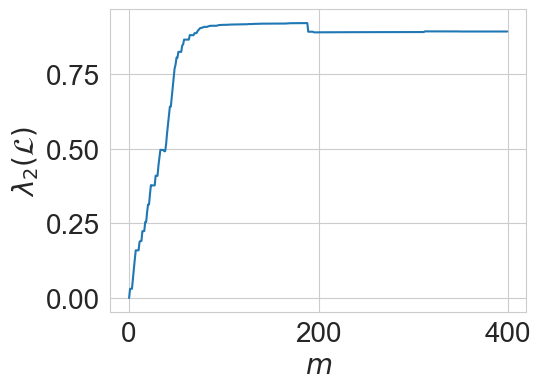

In [12]:
plt.clf()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('$m$', fontsize=20)
plt.ylabel(r'$\lambda_2(\mathbf{\mathcal{L}})$', fontsize=20)
plt.subplots_adjust(bottom=0.25)
plt.subplots_adjust(left=0.25)
plt.plot(range(m), algconns)
plt.show()

Since the random rewiring gradually increases the "connectedness" of the network, the algebraic connectivity of the network gradually increases as well. This confirms that the network becomes more and more efficient for diffusion processes.

## Counting connected components based on the Laplacian spectrum

In the lecture we have seen that we can rearrange the Laplacian matrix of a network with $k$ connected components into a block structure, where each block is again a Laplacian matrix with its own eigenvalue zero. This implies that the number of zeros in the Laplacian spectrum can be used to calculate the number of connected components of a network.

To test this, the following function counts the number of zeros in the Laplacian spectrum (up to tolerance due to numerical precision issues):

In [13]:
def Laplacian_zeros(network):
    L = laplacian(network)
    w, v = sp.linalg.eig(L.toarray())
    eigenvalues_sorted = np.sort(np.absolute(w))
    tol = 1e-15
    eigenvalues_sorted[eigenvalues_sorted < tol] = 0.0
    # count zeros and return number
    return network.number_of_nodes() - np.count_nonzero(eigenvalues_sorted)

For our toy network, we have only a single component:

In [15]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('b', 'd')
n.add_edge('d', 'f')
n.add_edge('d', 'g')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('f', 'g')

n.plot(edge_color='gray')

In [29]:
print('Number of connected components =', Laplacian_zeros(n))

Number of connected components = 1


In [16]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('d', 'f')
n.add_edge('d', 'g')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('f', 'g')

n.plot(edge_color='gray')
print('Number of connected components =', Laplacian_zeros(n))

Number of connected components = 2


In [17]:
n = pp.Network(directed=False)
n.add_node('a')
n.add_node('b')
n.add_node('c')
n.add_edge('d', 'f')
n.add_edge('d', 'g')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('f', 'g')

n.plot(edge_color='gray')
print('Number of connected components =', Laplacian_zeros(n))

Number of connected components = 4
